In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from scipy.integrate import odeint
from scipy.linalg import fractional_matrix_power
from sympy.abc import phi, theta, omega
from sympy import init_printing
from sympy.utilities.lambdify import lambdify
from IPython.display import HTML

init_printing() 

In [2]:
m_1, m_2, g, t, L_1, L_2, x_1, x_2, y_1, y_2, z_1, z_2 = sp.symbols("m_1 m_2 g t L_1 L_2 x_1 x_2 y_1 y_2 z_1 z_2")
x_1 = x_1(t)
x_2 = x_2(t)
y_1 = y_1(t)
y_2 = y_2(t)
z_1 = z_1(t)
z_2 = z_2(t)

In [3]:
const_1 = x_1**2 + y_1**2 + z_1**2 - L_1**2
const_2 = (x_2 - x_1)**2 + (y_2 - y_1)**2 + (z_2 - z_1)**2 - L_2**2

const_1_dd = const_1.diff(t, t)
const_2_dd = const_2.diff(t, t)

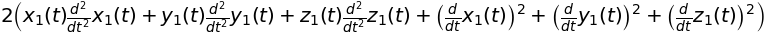

In [4]:
const_1_dd

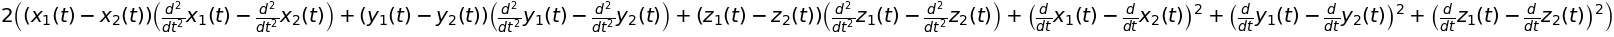

In [5]:
const_2_dd

In [6]:
xdd_1, ydd_1, zdd_1, xdd_2, ydd_2, zdd_2 = sp.symbols("\ddot{x_1} \ddot{y_1} \ddot{z_1} \ddot{x_2} \ddot{y_2} \ddot{z_2}")
xd_1, yd_1, zd_1, xd_2, yd_2, zd_2 = sp.symbols("\dot{x_1} \dot{y_1} \dot{z_1} \dot{x_2} \dot{y_2} \dot{z_2}")

In [7]:
const_1_dd_s = sp.expand(const_1_dd.subs({
    x_1.diff(t, t): xdd_1, y_1.diff(t, t): ydd_1, z_1.diff(t, t): zdd_1,
    x_2.diff(t, t): xdd_2, y_2.diff(t, t): ydd_2, z_2.diff(t, t): zdd_2,
    x_1.diff(t): xd_1, y_1.diff(t): yd_1, z_1.diff(t): zd_1,
    x_2.diff(t): xd_2, y_2.diff(t): yd_2, z_2.diff(t): zd_2
}))
const_2_dd_s = sp.expand(const_2_dd.subs({
    x_1.diff(t, t): xdd_1, y_1.diff(t, t): ydd_1, z_1.diff(t, t): zdd_1,
    x_2.diff(t, t): xdd_2, y_2.diff(t, t): ydd_2, z_2.diff(t, t): zdd_2,
    x_1.diff(t): xd_1, y_1.diff(t): yd_1, z_1.diff(t): zd_1,
    x_2.diff(t): xd_2, y_2.diff(t): yd_2, z_2.diff(t): zd_2
}))

In [8]:
const_1_dd_s

In [9]:
A_1, b_1 = sp.linear_eq_to_matrix([const_1_dd_s], [xdd_1, ydd_1, zdd_1, xdd_2, ydd_2, zdd_2])

In [10]:
const_2_dd_s

In [11]:
A_2, b_2 = sp.linear_eq_to_matrix([const_2_dd_s], [xdd_1, ydd_1, zdd_1, xdd_2, ydd_2, zdd_2])

In [12]:
A = sp.Matrix((A_1, A_2))
A

⎡     2⋅x₁(t)            2⋅y₁(t)            2⋅z₁(t)               0           
⎢                                                                             
⎣2⋅x₁(t) - 2⋅x₂(t)  2⋅y₁(t) - 2⋅y₂(t)  2⋅z₁(t) - 2⋅z₂(t)  -2⋅x₁(t) + 2⋅x₂(t)  

        0                   0         ⎤
                                      ⎥
-2⋅y₁(t) + 2⋅y₂(t)  -2⋅z₁(t) + 2⋅z₂(t)⎦

In [13]:
b = sp.Matrix((b_1, b_2))
b

⎡                                                                       2     
⎢                                                          - 2⋅\dot{x_1}  - 2⋅
⎢                                                                             
⎢             2                                      2              2         
⎣- 2⋅\dot{x_1}  + 4⋅\dot{x_1}⋅\dot{x_2} - 2⋅\dot{x_2}  - 2⋅\dot{y_1}  + 4⋅\dot

         2              2                                                     
\dot{y_1}  - 2⋅\dot{z_1}                                                      
                                                                              
                             2              2                                 
{y_1}⋅\dot{y_2} - 2⋅\dot{y_2}  - 2⋅\dot{z_1}  + 4⋅\dot{z_1}⋅\dot{z_2} - 2⋅\dot

      ⎤
      ⎥
      ⎥
     2⎥
{z_2} ⎦

In [14]:
A_f = lambdify(
    (x_1, y_1, z_1, x_2, y_2, z_2), 
    A, 'numpy')

In [15]:
b_f = lambdify((
    x_1, y_1, z_1, x_2, y_2, z_2,
    xd_1, yd_1, zd_1, xd_2, yd_2, zd_2,
    ), 
    b, 'numpy')

### Fundamental Equation
$\ddot x = a + M^{-1/2}(AM^{-1/2})^{+}(b-Aa)$

In [16]:
def double_pendulum(X, t, M, F):
    x_1, y_1, z_1, x_2, y_2, z_2, xd_1, yd_1, zd_1, xd_2, yd_2, zd_2 = X
    A = A_f(x_1, y_1, z_1, x_2, y_2, z_2)
    b = b_f(x_1, y_1, z_1, x_2, y_2, z_2, xd_1, yd_1, zd_1, xd_2, yd_2, zd_2)
    
    # Solving numerically for now
    a = np.linalg.solve(M, F).reshape(-1, 1)
    M_ = fractional_matrix_power(M, -0.5)
    x_dd = a + np.dot(M_, np.dot(np.linalg.pinv(np.dot(A, M_)), (b - np.dot(A, a))))
    X_d = np.hstack((np.array([xd_1, yd_1, zd_1, xd_2, yd_2, zd_2]), np.squeeze(x_dd)))
    return X_d

In [17]:
M = 2*np.eye(6)
F = np.array([0,0,1,0,0,1])
double_pendulum(np.array([0,2,0,0,4,0,0,0,0,0,0,0]), 0, M, F)

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,
        0.5])

In [28]:
dt = 0.001
var_t = np.arange(0, 100, dt) 
steps = len(var_t)
var_m_1 = 2.0
var_m_2 = 1.0
var_L_1 = 1.0
var_L_2 = 2.0
var_g = -9.81
var_M = np.diagflat([var_m_1, var_m_1, var_m_1, var_m_2, var_m_2, var_m_2])
var_F = np.array([0, 0, (var_m_1 * var_g), 0, 0, (var_m_2 * var_g)])
X_0 = [0, var_L_1, 0, 0, (var_L_1 + var_L_2), 0, 0, 0, 0, 0, 0, 0]
sol = odeint(double_pendulum, X_0, var_t, args=(var_M, var_F))

sim1_y1 = sol[:,1]
sim1_z1 = sol[:,2]
sim1_y2 = sol[:,4]
sim1_z2 = sol[:,5]

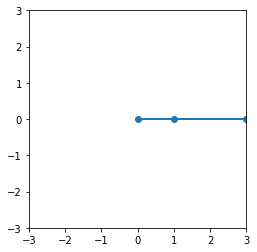

In [29]:
fps = 25.0
interval = 1000/fps
a_step = np.floor(1/fps/dt)
plot_ix = np.arange(0, steps, a_step).astype(int)
ix_range = plot_ix.shape[0]
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,  xlim=(-3, 3), ylim=(-3, 3))
line, = ax.plot([], [], 'o-', lw=2)
    
def animate(i, y1, z1, y2, z2):
    line.set_data([0, y1[i], y2[i]], [0, z1[i], z2[i]])
    return line

ani = animation.FuncAnimation(fig, animate, ix_range,
                              interval=interval, blit=False, fargs=(sim1_y1[plot_ix], sim1_z1[plot_ix], sim1_y2[plot_ix], sim1_z2[plot_ix]))
HTML(ani.to_html5_video())

In [30]:
dt = 0.001
var_t = np.arange(0, 20, dt) 
steps = len(var_t)
var_m_1 = 2.0
var_m_2 = 1.0
var_L_1 = 1.0
var_L_2 = 2.0
var_g = -9.81
var_M = np.diagflat([var_m_1, var_m_1, var_m_1, var_m_2, var_m_2, var_m_2])
var_F = np.array([0, 0, (var_m_1 * var_g), 0, 0, (var_m_2 * var_g)])
x1_i = var_L_1*np.cos(np.pi/2)
y1_i = var_L_1*np.sin(np.pi/2)
x2_i = x1_i + var_L_2
y2_i = y1_i
X_0 = [x1_i, y1_i, 0, x2_i, y2_i, 0, 0, 0, 0, 0, 0, 0]
sol = odeint(double_pendulum, X_0, var_t, args=(var_M, var_F))

sim2_x1 = sol[:, 0]
sim2_y1 = sol[:, 1]
sim2_z1 = sol[:, 2]
sim2_x2 = sol[:, 3]
sim2_y2 = sol[:, 4]
sim2_z2 = sol[:, 5]

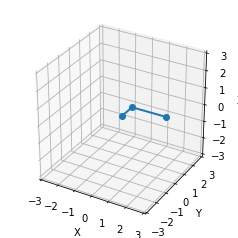

In [39]:
fps = 25.0
interval = 1000/fps
a_step = np.floor(1/fps/dt)
plot_ix = np.arange(0, steps, a_step).astype(int)
ix_range = plot_ix.shape[0]
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim3d([-3.0, 3.0])
ax.set_ylim3d([-3.0, 3.0])
ax.set_zlim3d([-3.0, 3.0])

line, = ax.plot([], [], [], 'o-', lw=2)
    
def animate(i, x1, y1, z1, x2, y2, z2):
    line.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    line.set_3d_properties([0, z1[i], z2[i]])
    return line

ani = animation.FuncAnimation(fig, animate, ix_range,
                              interval=interval, blit=False, fargs=(sim2_x1[plot_ix], sim2_y1[plot_ix], sim2_z1[plot_ix], 
                                                                    sim2_x2[plot_ix], sim2_y2[plot_ix], sim2_z2[plot_ix]))
HTML(ani.to_html5_video())